**Временной ряд** – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки
<br>Таким образом, данные оказываются упорядочены относительно неслучайных моментов времени, и, значит, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

import warnings
warnings.filterwarnings("ignore")

В качестве примера для работы возьмем реальные данные по часовому онлайну игроков в одной из мобильных игрушек:

In [2]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
                            x = df.index,
                            y = df[column],
                            mode = 'lines',
                            name = column
                        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [3]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

### Rolling window estimations
Начнем моделирование с наивного предположения — "завтра будет, как вчера", но вместо модели вида $\hat{y_t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней: $$ \hat{y_t} = \frac{1}{k}\sum_{n=0}^{k-1} y_{t-n}$$
Посмотрим на прогноз, построенный по последнему наблюдаемому дню (24 часа):

In [4]:
def moving_average(series, n):
    
    return np.average(series[-n:])

In [5]:
moving_average(dataset['Users'], 24)

29858.333333333332

К сожалению, такой прогноз долгосрочным сделать не удастся — для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение — сглаживание исходного ряда для выявления трендов. В пандасе есть готовая реализация — `DataFrame.rolling(window).mean()`. Чем больше зададим ширину интервала — тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь с определением общих паттернов.

Для нашего ряда тренды и так вполне очевидны, но если сгладить по дням, становится лучше видна динамика онлайна по будням и выходным (выходные — время поиграть), а недельное сглаживание хорошо отражает общие изменения, связанные с резким ростом числа активных игроков в феврале и последующим снижением в марте:

In [6]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 
    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

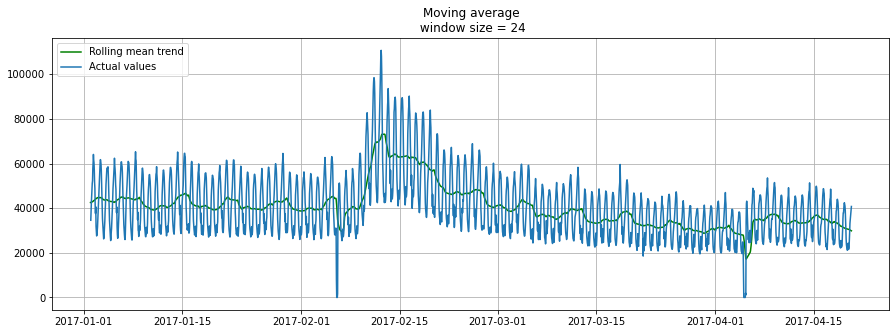

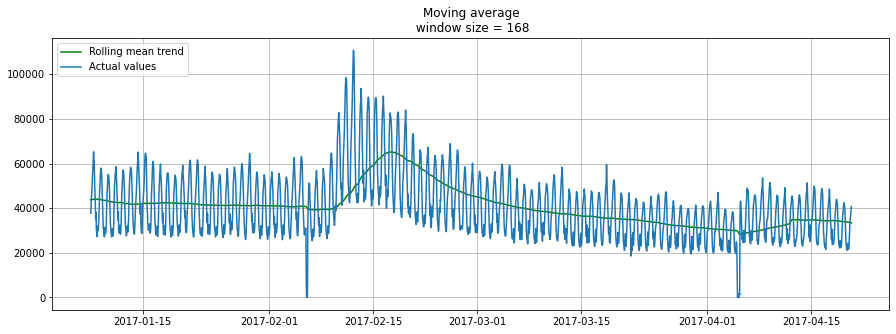

In [7]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

In [8]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 
    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

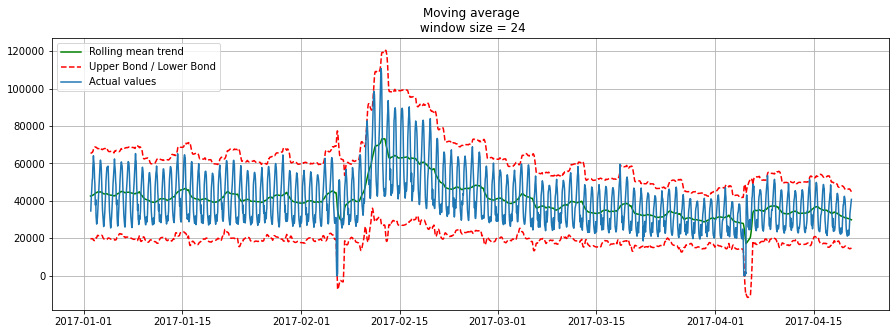

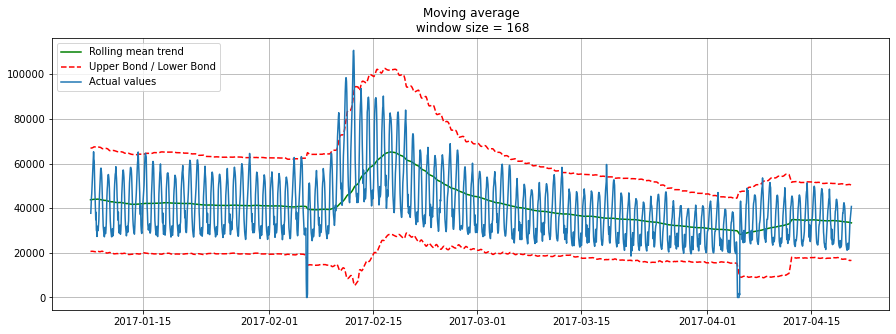

In [9]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес:
$$\hat{y_t} = \sum_{n=1}^{k} \omega_n y_{t+1-n}$$

In [10]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
        
    return result

In [11]:
weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

35967.55

---

### Экспоненциальное сглаживание, модель Хольта-Винтерса
А теперь посмотрим, что произойдёт, если вместо взвешивания последних  значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого экспоненциального сглаживания:
$$\hat{y_t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y_{t-1}}$$
Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд.

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        
    return result

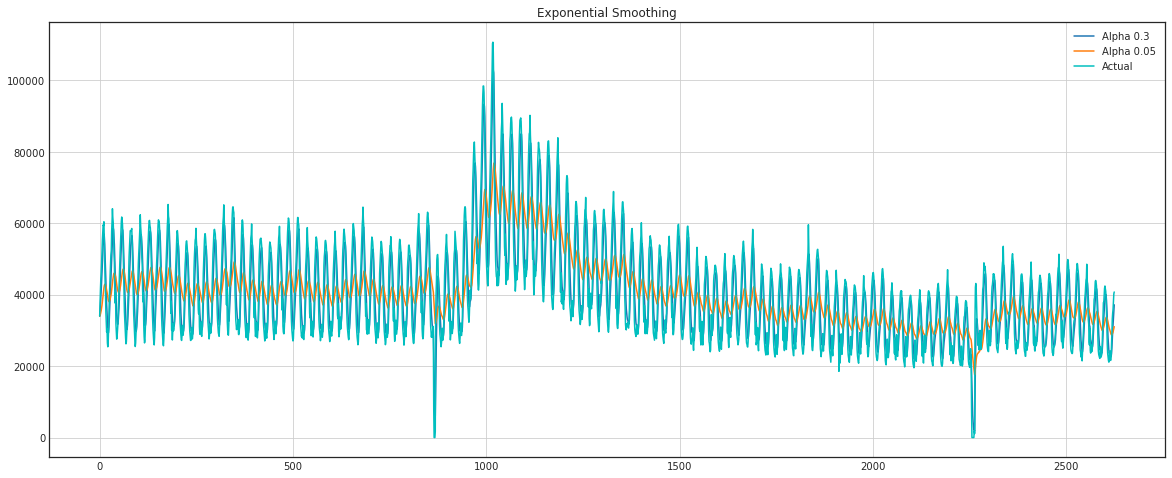

In [13]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).


В этом нам поможет разбиение ряда на две составляющие — уровень (level, intercept)  и тренд  (trend, slope):
$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1}) \\
b_x = \beta (\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} \\
\hat{y}_{x+1} = \ell_x + b_x$$

In [14]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    return result

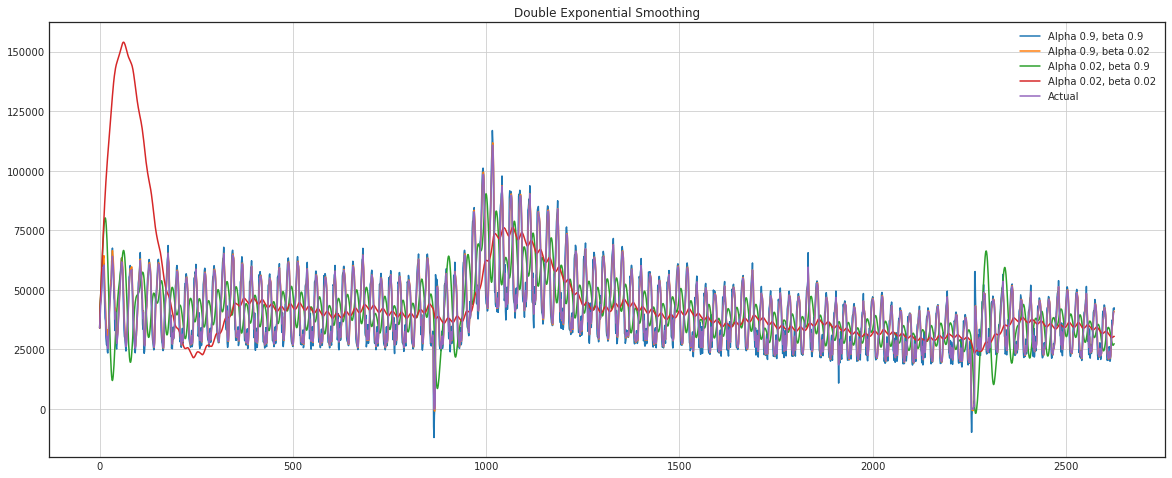

In [15]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Идея метода тройного экспоненциального сглаживания (a.k.a. Holt-Winters) заключается в добавлении еще одной, третьей, компоненты — сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

$$\ell_x = \alpha (y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1}) \\
b_x = \beta (\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} \\
s_x = \gamma (y_x - \ell_x) + (1-\gamma)s_{x-L} \\
\hat{y}_{x+m} = \ell_x + m b_x + s_{x-L+1+(m-1) mod L}$$

Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать:

In [16]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
            
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(
                                    self.series[self.slen*j:self.slen*j+self.slen]
                                    ) / float(self.slen))
            
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
            
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

---

### Кросс-валидация на временных рядах
<img src="1.png">

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров — каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае — Truncated Newton conjugate gradient:

In [19]:
%%time
data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, 
               x0=x, 
               method="TNC", 
               bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006635880294816432 0.0 0.046569454900318885
CPU times: user 10.9 s, sys: 35.8 ms, total: 10.9 s
Wall time: 10.9 s


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов):

In [20]:
# Передаем оптимальные значения модели, 
data = dataset['Users']

model = HoltWinters(data[:-128], 
                    slen = 24*7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 128, 
                    scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [21]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    
    plt.figure(figsize=(25, 10))
    
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

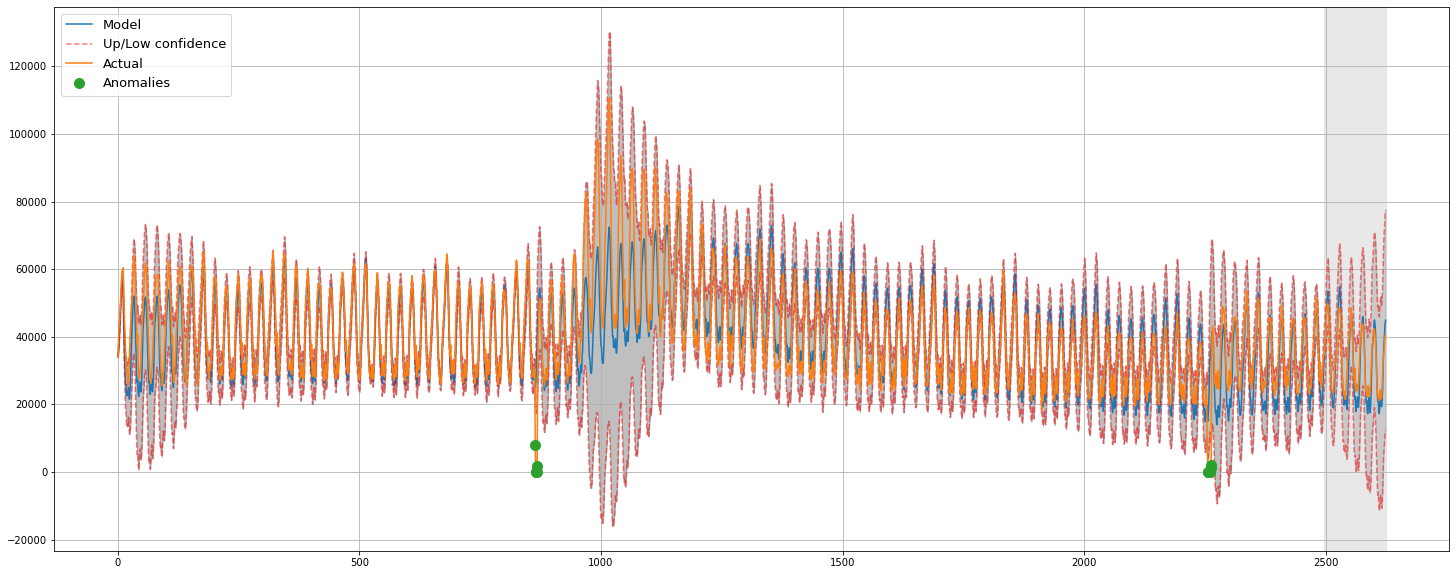

In [22]:
plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив недельную и дневную сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

---

### Эконометрический подход

Под **стационарностью** понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же **гомоскедастичность**) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).

По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными.

<br><img src="2.png" width="550">

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в друго:

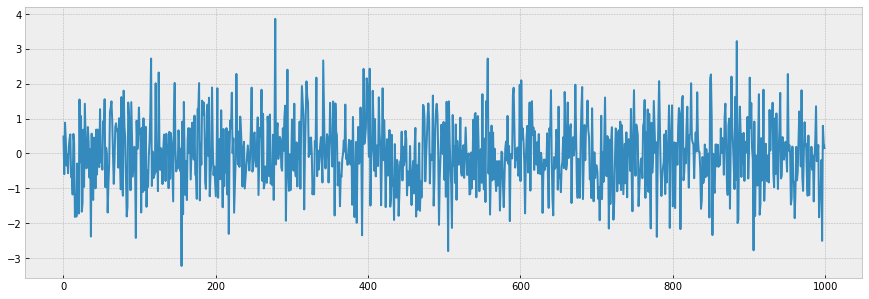

In [23]:
# График белого шума
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на основании него сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $$x_t = \rho x_{t-1} + e_{t}$$

In [24]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

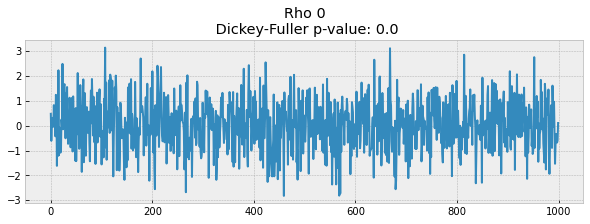

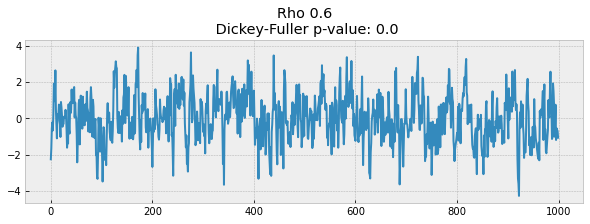

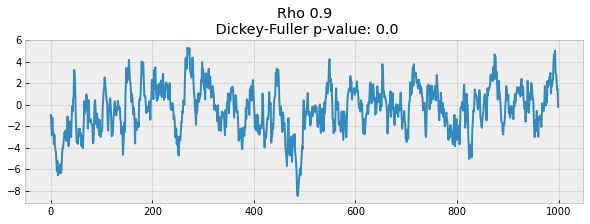

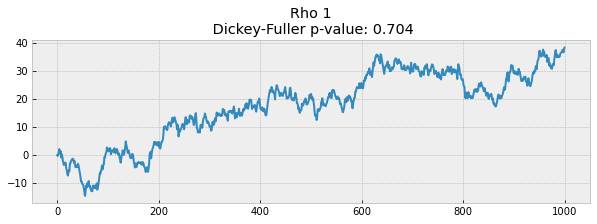

In [25]:
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение  увеличилось $\rho$ до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания — ряд не стационарен.

Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_{t}$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим $x_t - x_{t-1} = (\rho-1) x_{t-1} + e_{t}$, где выражение слева — первые разности. Если $ \rho = 1 $, то первые разности дадут стационарный белый шум $ e_t $. Этот факт лёг в основу теста Дики-Фуллера на стационарность ряда (наличие единичного корня).

Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка. Нулевая гипотеза теста — ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.

**Бороться с нестационарностью** можно множеством способов — разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

---

Попробуем теперь построить ARIMA модель для онлайна игроков, пройдя все круги ада стадии приведения ряда к стационарному виду:

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
        
    return 

Критерий Дики-Фуллера: p=0.190189


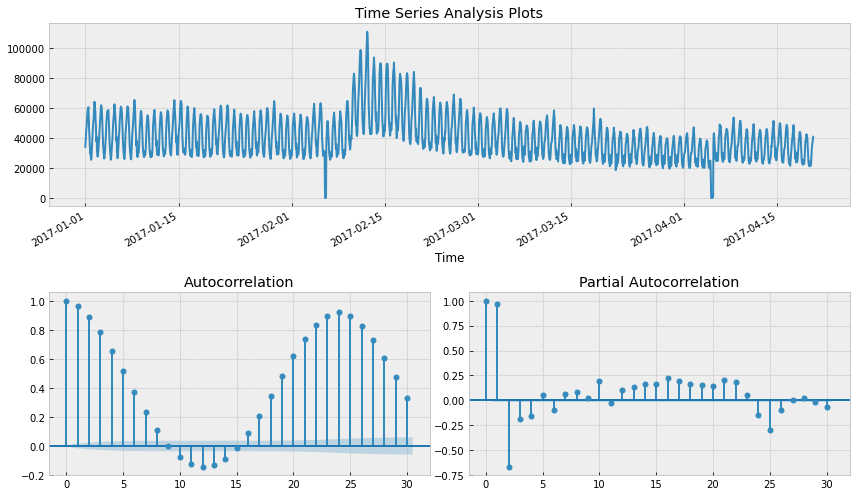

In [27]:
tsplot(dataset.Users, lags=30)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

<br><img src="3.png">
<img src="4.png">
<img src="5.png">

In [28]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Критерий Дики-Фуллера: p=0.079760
Оптимальный параметр преобразования Бокса-Кокса: 0.587270


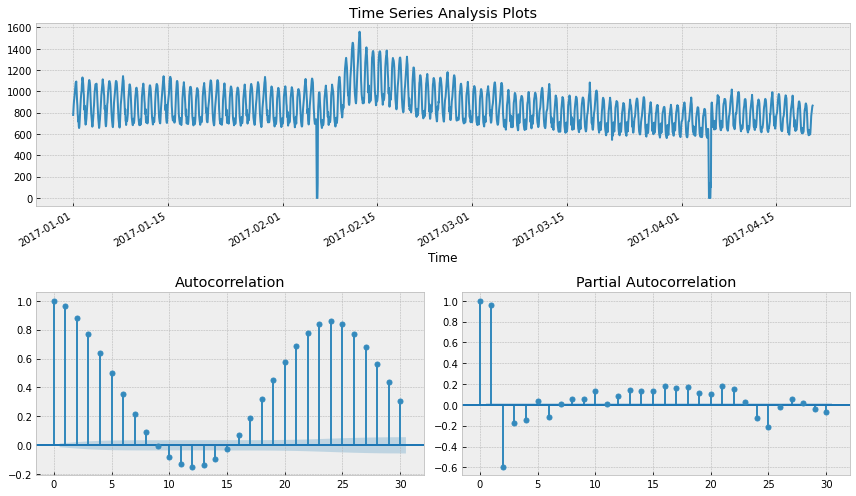

In [29]:
data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.Users+1) # прибавляем единицу, так как в исходном ряде есть нули

tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Уже лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.002571


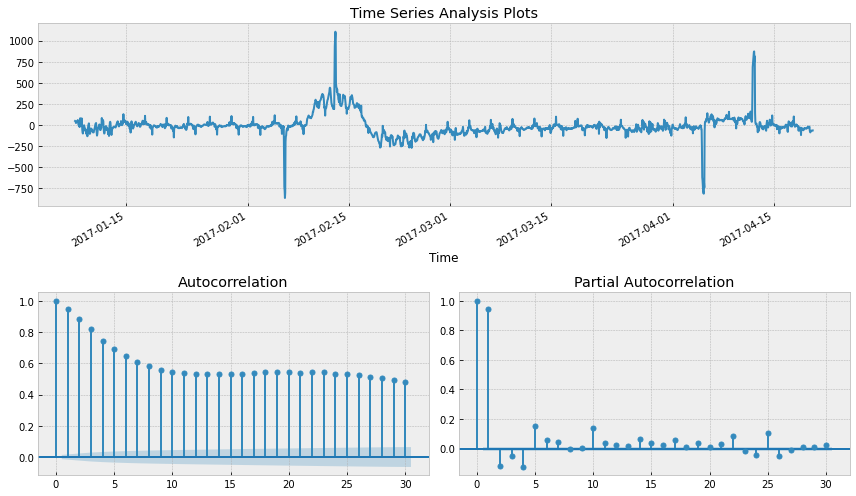

In [30]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести наконец ряд к стационарному виду:

Критерий Дики-Фуллера: p=0.000000


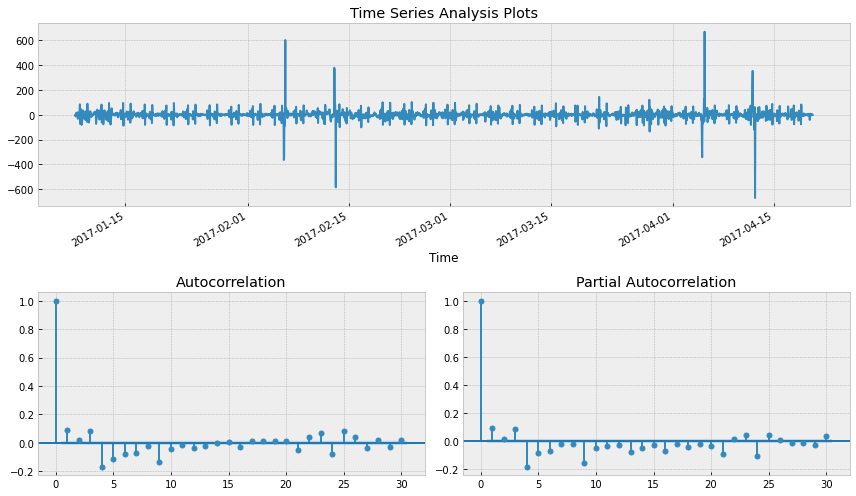

In [31]:
data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности:

In [32]:
from itertools import product

In [33]:
# Начальные приближения Q=1, P=4, q=3, p=4

ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [ ]:
# Код для подбора параметров перебором
# Считается очень долго, я не считал в итоге

%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Users_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
# Лучшие параметры вставляем в модель
# Считается тоже очень долго, я не считал
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary())

In [ ]:
# Проверим остатки модели
tsplot(best_model.resid[24:], lags=30)

Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели:

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data['Users'].values[-400:]

plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

<img src="6.png" width="800">

В финале получаем достаточно адекватный прогноз, в среднем модель ошибалась на 1.3 K пользователей, что очень и очень неплохо, однако суммарные затраты (в том числе временные) на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.

---

### Линейные и не только модели на временных рядах

Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – быстро, качественно, недорого. Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных (например, SARIMA), либо сложно настраиваются (хороший пример – SARIMA), либо требуют частого переобучения на новых данных (опять SARIMA), поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.

Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

**Извлечение признаков (Feature extraction)**
<br>Помимо стандартных признаков вроде лагов целевой переменной, много информации содержат в себе дата и время.

Еще один вариант кодирования категориальных признаков – кодирование средним. Если не хочется раздувать датасет множеством дамми-переменных, которые могут привести к потере информации о расстоянии, а в вещественном виде возникают противоречивые результаты ("0 часов < 23 часа"), то можно закодировать переменную средним значением целевой переменной. 

В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом игроков, находившихся в этот день недели или час онлайн. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тестового датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем:

In [34]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    
    return dict(data.groupby(cat_feature)[real_feature].mean())

Создадим новый датафрейм и добавим в него час, день недели и выходной в качестве категориальных переменных:

In [35]:
data = pd.DataFrame(dataset)
data.columns = ["y"]

data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

data.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


Посмотрим на средние по дням недели:

In [36]:
code_mean(data, 'weekday', "y")

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные:

In [37]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)
    data["hour_average"] = map(code_mean(data[:test_index], 'hour', "y").get, data.hour)

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

---

Обучим на получившихся данных простую **линейную регрессию**. При этом лаги будем брать начиная с двенадцатого, таким образом модель будет способна строить предсказания на 12 часов вперёд, имея фактические наблюдения за предыдущие пол дня:

In [38]:
from sklearn.linear_model import LinearRegression

In [ ]:
X_train, X_test, y_train, y_test = prepareData(dataset.Users, test_size=0.3, lag_start=12, lag_end=48)

lr = LinearRegression()
lr.fit(X_train, y_train)

prediction = lr.predict(X_test)

> Не знаю, чего хочет

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

<img src="8.png" width="800">

Получилось достаточно неплохо, даже отбора признаков модель ошибается, в среднем, на 3K пользователей в час, и это учитывая огромный выброс в середине тестового ряда.

Также можно провести оценку модели на кросс-валидации, тому же принципу, что был использован ранее:

In [39]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [ ]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

4613.17893150896

На 5 фолдах получили среднюю абсолютную ошибку в 4.6 K пользователей, достаточно близко к оценке качества, полученной на тестовом датасете.

---

Почему бы теперь не попробовать **XGBoost**?

In [40]:
import xgboost as xgb

In [41]:
def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [ ]:
XGB_forecast(dataset, test_size=0.2, lag_start=5, lag_end=30)

> Хочет того же

<img src="9.png" width="800">
<img src="10.png" width="800">

Те же 3k пользователей в средней абсолютной ошибке, и неплохо пойманные аномалии на тестовом датасете. Конечно, чтобы уменьшить ошибку, еще можно повозиться с параметрами, настроить при необходимости регуляризацию, отобрать признаки, понять, на сколько лагов нужно уходить вглубь истории и т.д.